### Note: In this workspace, I've tried to pay special attention to Accuracy so that there is an improvement in it.Please don't just look at this workspace, it's extra space.###

# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [2]:
!pip install torch

In [3]:
!pip install torchvision

In [4]:
!pip install --upgrade matplotlib

In [5]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import datasets
import os
from IPython.display import display, Image as IPImage

In [6]:
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [7]:
from torchvision.datasets import CIFAR10
image_size = (32, 32)
# Define transforms
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),  
                                transforms.Resize(image_size),])

# Create training set and define training dataloader
trainset= CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=transform )
trainloader= torch.utils.data.DataLoader(trainset, batch_size=75, shuffle= True)

# Create test set and define test dataloader
testset= CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=transform )
testloader= torch.utils.data.DataLoader(testset, batch_size=75, shuffle= True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
#To ensure that the data has been downloaded and uploaded successfully
dataiter= iter(trainloader)
images, labels= dataiter.__next__()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([75, 3, 32, 32])
torch.Size([75])


C:\Users\96655\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

Training Set: 


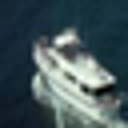

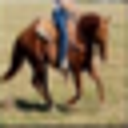

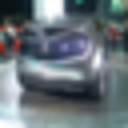

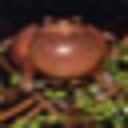

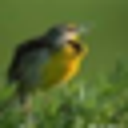

In [9]:
#Explore data
#As shown, I used another function that differs from the one given, since I prefer this function more
#First: Explore Training Set
print("Training Set: ")

# Get a batch of data from the trainloader
data_iter = iter(trainloader)
images, labels = next(data_iter)

# Loop through the images and save and display them
for i in range(5):
    image = images[i].permute(1, 2, 0)  # Transpose the image tensor for visualization
    image = (image * 0.5 + 0.5) * 255  # Convert image tensor to [0, 255] range
    image = image.byte()  # Convert image tensor to byte format (0-255)
    
    # Create a PIL image from the byte tensor
    pil_image = Image.fromarray(image.numpy())
    
    # Increase image size
    new_size = (pil_image.size[0] * 4, pil_image.size[1] * 4)
    pil_image_resized = pil_image.resize(new_size)
    
    # Save the image to a file
    image_filename = f"image_{i}.png"
    pil_image_resized.save(image_filename)
    
    # Display the saved image using IPython.display
    display(IPImage(filename=image_filename))   
    
    # Delete the saved image file to avoid cluttering the directory
    os.remove(image_filename)

Testing Set: 


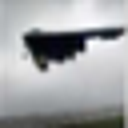

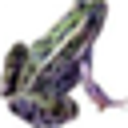

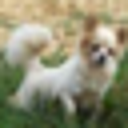

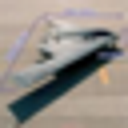

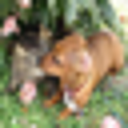

In [10]:
#Second: Explore Testing Set

print("Testing Set: ")

data_iter = iter(testloader)
images, labels = next(data_iter)

for i in range(5): 
    image = images[i].permute(1, 2, 0)
    image = (image * 0.5 + 0.5) * 255 
    image = image.byte() 
    
    pil_image = Image.fromarray(image.numpy())
     
    new_size = (pil_image.size[0] * 4, pil_image.size[1] * 4)
    pil_image_resized = pil_image.resize(new_size)
    
    image_filename = f"test_image_{i}.png"  
    pil_image_resized.save(image_filename)
    
    display(IPImage(filename=image_filename))
    
    os.remove(image_filename)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [11]:
# flatten the input images
inputs= images.view(images.shape[0], -1)
print(inputs.shape)

torch.Size([75, 3072])


In [12]:
# Define network architecture
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(3072, 1500)
        self.fc2 = nn.Linear(1500, 800)
        self.fc3 = nn.Linear(800, 400)
        self.fc4 = nn.Linear(400, 200)
        self.fc5 = nn.Linear(200, 10)
       # I observed that omitting Dropout tends to improve test set accuracy; however, 
       #to maintain model robustness and mitigate overfitting risks, I will include Dropout layers in the architecture.
        self.dropout = nn.Dropout(0.1)
    def forward(self, inputs):
        inputs = F.relu(self.fc1(inputs))
        inputs = self.dropout(inputs)
        inputs = F.relu(self.fc2(inputs))
        inputs = self.dropout(inputs)
        inputs = F.relu(self.fc3(inputs))
        inputs = self.dropout(inputs)
        inputs = F.relu(self.fc4(inputs))
        inputs = self.dropout(inputs)
        inputs = F.log_softmax(self.fc5(inputs), dim=1)
        return inputs

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

## Answer ##

### loss function: ###
I've used the **CrossEntropyLoss** as the loss function, which is commonly used for multi-class classification tasks. It's suitable for problems where each input data point belongs to one of multiple classes.
### optimizer: ###
I chose to utilize the **Adam** optimizer, as it strikes a balance between rapid convergence and smooth optimization by incorporating historical gradient information. This choice was made to enhance training efficiency while avoiding potential oscillations during optimization.
### instantiate the model: ###
Instantiate a neural network model with hidden layers using the specified architecture, optimizer, and learning rate for efficient training and parameter tuning.


In [13]:
# Instantiate the model
model = Classifier()

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer 
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []         
epochs = 20

for e in range(epochs):
    running_loss = 0
    
    model.train()  # Set the model to training mode
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Store the average training loss for this epoch
        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

    print(f"Epoch {e+1} - Training loss: {running_loss/len(trainloader)}")

Epoch 1 - Training loss: 1.727609025127348
Epoch 2 - Training loss: 1.5334401917064386
Epoch 3 - Training loss: 1.4346529992445298
Epoch 4 - Training loss: 1.351088467655868
Epoch 5 - Training loss: 1.277720816757368
Epoch 6 - Training loss: 1.2229936746643044
Epoch 7 - Training loss: 1.1637467126260097
Epoch 8 - Training loss: 1.106962370461431
Epoch 9 - Training loss: 1.065480420793193
Epoch 10 - Training loss: 1.012877072619534
Epoch 11 - Training loss: 0.9595188458283981
Epoch 12 - Training loss: 0.9263693101402523
Epoch 13 - Training loss: 0.8846842424086724
Epoch 14 - Training loss: 0.8526657419851695
Epoch 15 - Training loss: 0.8157718408143503
Epoch 16 - Training loss: 0.7851951403775137
Epoch 17 - Training loss: 0.748726299990421
Epoch 18 - Training loss: 0.7273200661882289
Epoch 19 - Training loss: 0.6969593139155873
Epoch 20 - Training loss: 0.6762773849438691


Plot the training loss (and validation loss/accuracy, if recorded).

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [15]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
test_loss = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.shape[0], -1)
        #Passes the flattened input images through the trained model to obtain the log probabilities of each class for each image.
        log_ps = model(inputs)
        #Computes the index of the class with the highest log probability for each image, resulting in the predicted class labels.
        _, predicted = torch.max(log_ps, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = (correct / total) * 100
print(f"Test accuracy: {test_accuracy:.2f}%")

Test accuracy: 55.13%


## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')